In [ ]:
!gdown --id 1s86bAl0e12yhUQYSVdRjVAAImtQR70eG # training.csv

In [ ]:
!pip install nltk
!pip install transformers
!pip install shutup
!pip install pytorch-lightning

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from matplotlib import rc

RANDOM_SEED = 17

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
pl.seed_everything(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Data Preprocess

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('training.csv', sep='\t')
df.rename(columns = {'Text Transcription': 'text'}, inplace = True)
df.head()

,file_name,misogynous,shaming,stereotype,objectification,violence,text
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((9500, 7), (500, 7))

In [ ]:
from nltk import word_tokenize
import re 

nltk.download('punkt')

def preprocess_text(text):
  text = text.lower()

  # Remove extra whitespaces
  text = text.strip()

  # Remove twitter usernames, web addresses
  text = text = re.sub(r"#[\w\d]*|@[.]?[\w\d]*[\'\w*]*|https?:\/\/\S+\b|"r"www\.(\w+\.)+\S*|", '', text)

  # Remove html tags
  text = re.sub(re.compile('<.*?>'), ' ', text)

  # Remove unwanted characters
  text = word_tokenize(text)
  text = ' '.join(word for word in text if word.isalpha() or word.isnumeric() or word.isalnum())
  
  return text

In [ ]:
train_df.text = np.array([preprocess_text(text) for text in train_df.text])
val_df.text = np.array([preprocess_text(text) for text in val_df.text])

In [ ]:
print(train_df.shape)

(9500, 7)


# Tokenization

We need to convert the raw text into a list of tokens. For that, we’ll use the built-in RobertaTokenizer:

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:-1]
LABEL_COLUMNS

['misogynous', 'shaming', 'stereotype', 'objectification', 'violence']

In [ ]:
ROBERTA_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Let’s try it out on a sample text

In [ ]:
sample_row = train_df.iloc[17]
sample_text = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_text)
print()
print(sample_labels.to_dict())

i totally support equality in the workplace m i want all women to be able to get home in time to make dinner for their family emeg

{'misogynous': 1, 'shaming': 0, 'stereotype': 1, 'objectification': 0, 'violence': 0}


In [ ]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=64,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 64]), torch.Size([1, 64]))

The result of the encoding is a dictionary with token ids (input_ids) and an attention mask  (which tokens should be used by the model 1 - use or 0 - don’t use).

Let’s look at their contents:

In [ ]:
encoding["input_ids"].squeeze()

tensor([   0,  118, 4940,  323, 9057,   11,    5, 7637,  475,  939,  236,   70,
         390,    7,   28,  441,    7,  120,  184,   11,   86,    7,  146, 3630,
          13,   49,  284, 2841, 3733,    2,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])

In [ ]:
encoding["attention_mask"].squeeze()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Text(0.5, 0, 'Sequence Length')

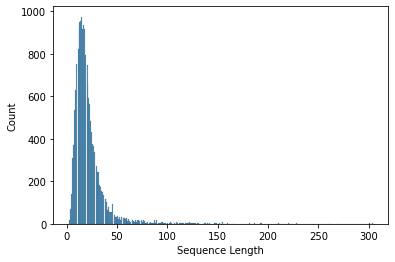

In [ ]:
token_lens = []

def calculate_seq_length(df):
  for txt in train_df.text:
    tokens = tokenizer.encode(str(txt))
    token_lens.append(len(tokens))

calculate_seq_length(train_df.text)
calculate_seq_length(val_df.text)

sns.histplot(token_lens)
plt.xlabel('Sequence Length')

In [ ]:
MAX_LEN = 64

# Dataset
We’ll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [ ]:
class MAMIDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer: RobertaTokenizer, max_len: int):
    self.tokenizer = tokenizer
    self.data = data
    self.max_len = max_len
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let’s have a look at a sample item from the dataset:


In [ ]:
train_dataset = MAMIDataset(
  train_df,
  tokenizer,
  max_len=MAX_LEN
)
sample_item = train_dataset[324]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(sample_item['text'])
print(sample_item["labels"])
print(sample_item['input_ids'].shape)

memes in march 2020 i like my women how i like my covid 19 and easy to get memes in april 2020 like my women how i like my whiskey and cola sweet and cold
tensor([1., 0., 0., 1., 1.])
torch.Size([64])


Let’s load the RoBERTa model and pass a sample of batch data through:



In [ ]:
roberta_model = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 64]), torch.Size([8, 64]))

In [ ]:
output = roberta_model(sample_batch["input_ids"], sample_batch["attention_mask"])

print(output.last_hidden_state.shape, output.pooler_output.shape)

roberta_model.config.hidden_size # The 768 dimension comes from the RoBERTa hidden size

torch.Size([8, 64, 768]) torch.Size([8, 768])


768

We’ll wrap our custom dataset into a LightningDataModule:



In [ ]:
class MAMIDataModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, tokenizer, batch_size=32, max_len=64):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def setup(self, stage=None):
    self.train_dataset = MAMIDataset(self.train_df, self.tokenizer, self.max_len)
    self.val_dataset = MAMIDataset(self.val_df, self.tokenizer, self.max_len)
  
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size,
        shuffle=True,
        num_workers=2
    )
  
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size = self.batch_size,
        num_workers=2
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size = self.batch_size,
        num_workers=2
    )

MAMIDataModule encapsulates all data loading logic and returns the necessary data loaders. Let’s create an instance of our data module:

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 32

data_module = MAMIDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_len=MAX_LEN
)

# Model

In [ ]:
class MemesClassifier(pl.LightningModule):
  
  def __init__(self, n_classes, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.roberta = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.roberta.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  
  
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.roberta(input_ids, attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)

    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)

    return {"loss":loss, 'predictions':outputs, 'labels':labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)

    return loss
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps = self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

In [ ]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(592, 2960)

In [ ]:
model = MemesClassifier(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training 

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min",
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="memes-text")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | roberta    | RobertaModel | 124 M 
1 | classifier | Linear       | 3.8 K 
2 | criterion  | BCELoss      | 0     
--------------------------------------------
124 M     Trainable params
0     

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 17


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 296: val_loss reached 0.43120 (best 0.43120), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 593: val_loss reached 0.39940 (best 0.39940), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 890: val_loss reached 0.38833 (best 0.38833), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trained_model = MemesClassifier.load_from_checkpoint(
  '/content/checkpoints/best-checkpoint.ckpt',
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = MAMIDataset(
  val_df,
  tokenizer,
  max_len=MAX_LEN
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=0.5)

tensor(0.8316)

In [ ]:
from google.colab import files
files.download('/content/checkpoints/best-checkpoint.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's predict some raw text

In [ ]:
text = 'me when dishwashers say they want equal rights:'

encoded_text = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

_, prediction = trained_model(
    input_ids,
    attention_mask)
prediction

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([[0.9684, 0.0666, 0.8011, 0.2701, 0.4897]], device='cuda:0')